In [1]:
import sys
sys.path.append(r'c:\checkouts\python\TUD-COASTAL\python\instrumentProcessing')
import os
import puv
import numpy as np
import xarray as xr

In [2]:
# input specification
instrFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\QC\vec1.nc"
ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"

# Ensure the input file exists
if not os.path.exists(instrFile):
    raise FileNotFoundError(f"The input file does not exist: {instrFile}")

# Ensure the output directory exists
out_dir = os.path.dirname(ncOutFile)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
     
# frequency resolution in fourier space
fresolution = 0.03125
#number of directional bins 
ntheta = 64
  
# load the raw data from netcdf
ds0 = xr.open_dataset(instrFile).load()

c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# interpolate nans
N = len(ds0.N)
for var in ['u', 'v', 'p', 'eta']:
    # interpolate the bursts where there is less than 5% nans
    data = ds0[var].where(
        np.isnan(ds0[var]).sum(dim='N') < 0.05 * len(ds0.N)
    ).dropna(dim='t', how='all')
    if len(data.t) != 0:
        ds0[var] = data.interpolate_na(
            dim='N',
            method='cubic',
            max_gap=8)

    # and fill the gaps more than 8 in length with the burst average
    ds0[var] = ds0[var].fillna(ds0[var].mean(dim='N'))

ds0 = ds0.dropna(dim='t')

# make a new dataset that has an extra dimension to accomodate for the frequency axis
ds = xr.Dataset(data_vars={},
          coords = {'t': ds0.t.values,
                    'N': ds0.N.values,
                    'f': np.arange(0, ds0.sf.values/2, fresolution),
                    'theta': np.arange(start=-np.pi,stop=np.pi,step=2*np.pi/ntheta)})
ds['f'].attrs = {'units': 'Hz'}
ds.attrs = ds0.attrs

# put all variables in this new dataset
for key in ds0.data_vars:
    ds[key] = ds0[key]


# extract sampling frequency as explicit variable
sf = ds.f.values          

# compute water depth
ds['h'] = ds['zsmean']-ds['zb']   


# do several wave statistics computations, only based on pressure
ufunc = lambda x, h: puv.attenuation_corrected_wave_spectrum(
    'pressure',
    ds.sf.values, x, h,
    ds.zi.values,
    ds.zb.values,
    fresolution=fresolution)

fx, ds['vy'] = xr.apply_ufunc(ufunc,
                        ds['p'], ds['h'],
                        input_core_dims=[['N'], []],
                        output_core_dims=[['f'], ['f']],
                        vectorize=True) 
ds['vy'].attrs = {'units': 'm2/Hz', 'long_name': 'spectral density'}
               

ufunc = lambda vy: puv.get_peak_frequency(ds.f.values, vy)
ds['fp'] = xr.apply_ufunc(ufunc,
                        ds['vy'],
                        input_core_dims=[['f']],
                        output_core_dims=[[]], 
                        vectorize=True) 
 
ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, vy, fmin=0.5*fp, fmax=5)
ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['fp'],
                        input_core_dims=[['f'], []],
                        output_core_dims=[[], [], [], [], [], []],
                        vectorize=True) 
ds['Hm0'].attrs = {'units': 'm', 'long_name': 'significant wave height','computation':'computed between fmin=0.5fp and fmax=5'}
ds['Tp'].attrs = {'units': 's', 'long_name': 'peak wave period','computation':'computed between fmin=0.5fp and fmax=5'}
ds['Tm01'].attrs = {'units': 's', 'long_name': 'mean wave period','computation':'computed between fmin=0.5fp and fmax=5'}
ds['Tm02'].attrs = {'units': 's', 'long_name': 'mean wave period','computation':'computed between fmin=0.5fp and fmax=5'}
ds['Tmm10'].attrs = {'units': 's', 'long_name': 'mean wave period','computation':'computed between fmin=0.5fp and fmax=5'}
ds['Tps'].attrs = {'units': 's', 'long_name': 'peak wave period','computation':'computed between fmin=0.5fp and fmax=5', 'comment':'smoothed estimate from the discrete spectrum'}


# compute current magnitudes and direction all computed in the time domain
ds['u_mean'] = ds.u.mean(axis=1)
ds['u_mean'].attrs = {'units': 'm/s', 'long_name': 'current x-component', 'computation': 'burst averaged'}

ds['v_mean'] = ds.v.mean(axis=1)
ds['v_mean'].attrs = {'units': 'm/s', 'long_name': 'current y-component', 'computation': 'burst averaged'}
               
ds['cur_dir'] = np.arctan2(ds['v_mean'], ds['u_mean'])*180/np.pi
ds['v_mean'].attrs = {'units': 'deg', 'long_name': 'current direction, cartesian convention'}

# directional wave spectra

ufunc = lambda p, u, v, h, fp: puv.wave_MEMpuv(p/1e4, u, v, h,
                    ds.zi.values,
                    ds.zb.values,
                    ds.sf.values,
                    fresolution=fresolution,
                    ntheta=ntheta,
                    fcorrmin=0.5*fp,
                    fcorrmax=5,
                    maxiter=20)
            
fx, vy, theta, ds['S'] = xr.apply_ufunc(ufunc,
                        ds['p'], ds['u'], ds['v'], ds['h'], ds['fp'],
                        input_core_dims=[['N'], ['N'], ['N'], [], []],
                        output_core_dims=[['f'], ['f'], ['theta'], ['f', 'theta']],
                        vectorize=True) 
ds['S'].attrs = {'units': 'm2/Hz/rad', 'long_name': 'directional variance density',
                 'computation': 'computed between fmin=0.5fp and fmax=5'}

# statistics from directional wave spectra
ufunc = lambda vy,S,fp: puv.compute_wave_params(ds.f.values, vy, fmin=0.5*fp, fmax=5, theta=ds.theta.values, S=S)
Hm0, Tp, Tm01, Tm02, Tmm10, Tps, ds['wavedirmean'],ds['dirspread'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['S'], ds['fp'],
                        input_core_dims=[['f'], ['f', 'theta'], []],
                        output_core_dims=[[], [], [], [], [], [], [], []],
                        vectorize=True) 
ds['wavedirmean'].attrs = {'units': 'deg', 'long_name': 'mean wave direction', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['dirspread'].attrs = {'units': 'deg', 'long_name': 'directional spreading', 'computation': 'computed between fmin=0.5fp and fmax=5'}
           
        
# write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
dsTailored = ds.drop_dims('N')
dsTailored.to_netcdf(ncOutFile)

 


c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the tailored NetCDF file
ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"
ds = xr.open_dataset(ncOutFile)

# Print the dataset structure to understand what variables are available
print(ds)

<xarray.Dataset> Size: 27MB
Dimensions:      (t: 203, f: 256, theta: 64)
Coordinates:
  * t            (t) datetime64[ns] 2kB 2020-11-30T17:00:00 ... 2020-12-02T16...
  * f            (f) float64 2kB 0.0 0.03125 0.0625 ... 7.906 7.938 7.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
Data variables: (12/39)
    sf           float64 8B ...
    pm           (t) float64 2kB ...
    um           (t) float64 2kB ...
    vm           (t) float64 2kB ...
    wm           (t) float64 2kB ...
    anl1m        (t) float64 2kB ...
    ...           ...
    u_mean       (t) float64 2kB ...
    v_mean       (t) float64 2kB ...
    cur_dir      (t) float64 2kB ...
    S            (t, f, theta) float64 27MB ...
    wavedirmean  (t) float64 2kB ...
    dirspread    (t) float64 2kB ...
Attributes: (12/16)
    Conventions:               CF-1.6
    title:                     vec1
    instrument:                vec1
    instrument serial number:  16725
    epsg:      

In [8]:
ds

<xarray.Dataset> Size: 27MB
Dimensions:      (t: 203, f: 256, theta: 64)
Coordinates:
  * t            (t) datetime64[ns] 2kB 2020-11-30T17:00:00 ... 2020-12-02T16...
  * f            (f) float64 2kB 0.0 0.03125 0.0625 ... 7.906 7.938 7.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
Data variables: (12/39)
    sf           float64 8B ...
    pm           (t) float64 2kB ...
    um           (t) float64 2kB ...
    vm           (t) float64 2kB ...
    wm           (t) float64 2kB ...
    anl1m        (t) float64 2kB ...
    ...           ...
    u_mean       (t) float64 2kB ...
    v_mean       (t) float64 2kB ...
    cur_dir      (t) float64 2kB ...
    S            (t, f, theta) float64 27MB ...
    wavedirmean  (t) float64 2kB ...
    dirspread    (t) float64 2kB ...
Attributes: (12/16)
    Conventions:               CF-1.6
    title:                     vec1
    instrument:                vec1
    instrument serial number:  16725
    epsg:                      28992
    x:                         117196.6
    ...                        ...
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     03-Dec-2024 (10:41:43)
    version:                   v2
    version comments:          constructed with xarray
    comment:                   Quality checked data: pressure reference level...

<xarray.Dataset> Size: 27MB
Dimensions:      (t: 203, f: 256, theta: 64)
Coordinates:
  * t            (t) datetime64[ns] 2kB 2020-11-30T17:00:00 ... 2020-12-02T16...
  * f            (f) float64 2kB 0.0 0.03125 0.0625 ... 7.906 7.938 7.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
Data variables: (12/39)
    sf           float64 8B ...
    pm           (t) float64 2kB ...
    um           (t) float64 2kB ...
    vm           (t) float64 2kB ...
    wm           (t) float64 2kB ...
    anl1m        (t) float64 2kB ...
    ...           ...
    u_mean       (t) float64 2kB ...
    v_mean       (t) float64 2kB ...
    cur_dir      (t) float64 2kB ...
    S            (t, f, theta) float64 27MB ...
    wavedirmean  (t) float64 2kB ...
    dirspread    (t) float64 2kB ...
Attributes: (12/16)
    Conventions:               CF-1.6
    title:                     vec1
    instrument:                vec1
    instrument serial number:  16725
    epsg:      

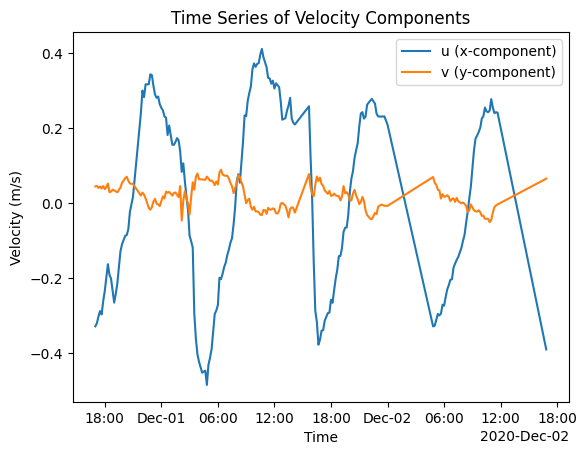

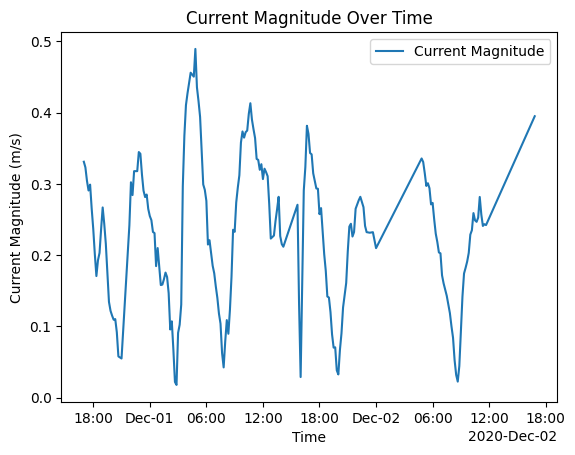

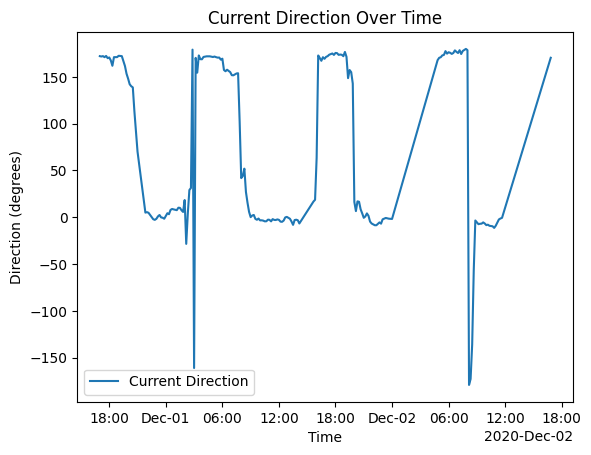

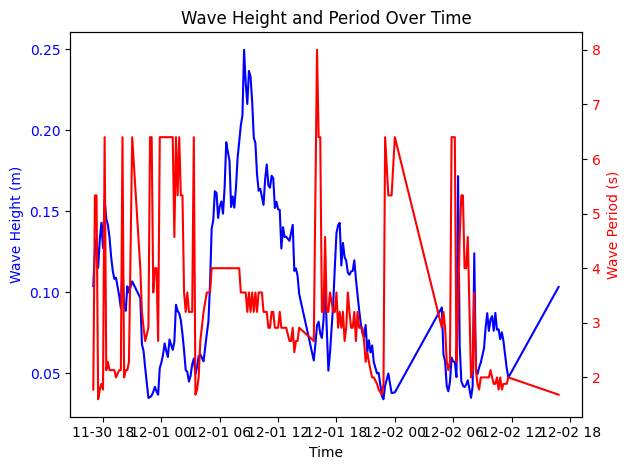

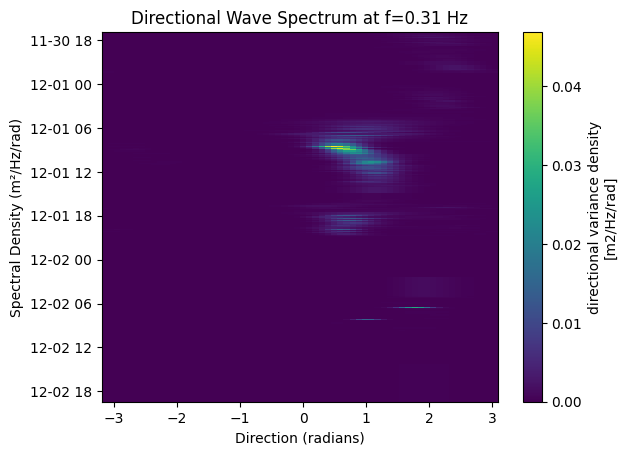

c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 203, using nperseg = 203
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


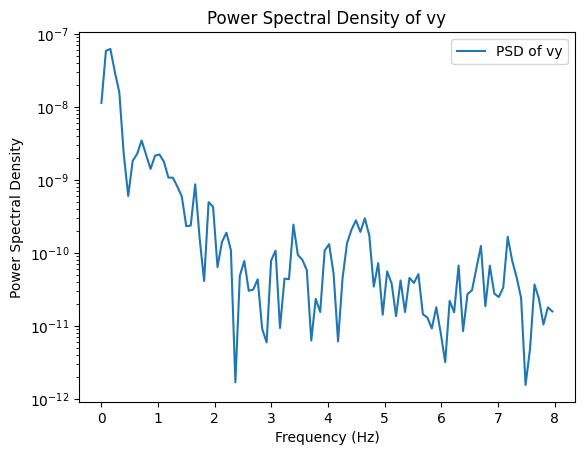

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the tailored NetCDF file
ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"
ds = xr.open_dataset(ncOutFile)

# Print the dataset structure to understand what variables are available
print(ds)

# 1. Time Series of Velocity Components (u_mean, v_mean)
if 'u_mean' in ds and 'v_mean' in ds:
    ds['u_mean'].plot(label="u (x-component)")
    ds['v_mean'].plot(label="v (y-component)")
    plt.title("Time Series of Velocity Components")
    plt.xlabel("Time")
    plt.ylabel("Velocity (m/s)")
    plt.legend()
    plt.show()

# 2. Current Magnitude and Direction
if 'u_mean' in ds and 'v_mean' in ds:
    current_magnitude = np.sqrt(ds['u_mean']**2 + ds['v_mean']**2)
    current_magnitude.plot(label="Current Magnitude")
    plt.title("Current Magnitude Over Time")
    plt.xlabel("Time")
    plt.ylabel("Current Magnitude (m/s)")
    plt.legend()
    plt.show()

    if 'cur_dir' in ds:
        ds['cur_dir'].plot(label="Current Direction")
        plt.title("Current Direction Over Time")
        plt.xlabel("Time")
        plt.ylabel("Direction (degrees)")
        plt.legend()
        plt.show()

# 3. Wave Height (Hm0) and Wave Period (Tp)
if 'Hm0' in ds and 'Tp' in ds:
    fig, ax1 = plt.subplots()

    # Plot Hm0 on the primary y-axis
    ax1.plot(ds['t'], ds['Hm0'], label="Hm0 (Wave Height)", color='b')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Wave Height (m)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot Tp on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(ds['t'], ds['Tp'], label="Tp (Wave Period)", color='r')
    ax2.set_ylabel("Wave Period (s)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title("Wave Height and Period Over Time")
    fig.tight_layout()
    plt.show()

# 4. Directional Wave Spectrum (S)
if 'S' in ds:
    freq_idx = 10  # Select a specific frequency index for the example
    if freq_idx < len(ds['f']):
        ds['S'].isel(f=freq_idx).plot(x='theta', yincrease=False)
        plt.title(f"Directional Wave Spectrum at f={ds['f'][freq_idx].values:.2f} Hz")
        plt.xlabel("Direction (radians)")
        plt.ylabel("Spectral Density (m²/Hz/rad)")
        plt.show()

# 5. Power Spectral Density (vy)
if 'vy' in ds:
    from scipy.signal import welch

    # Compute PSD for 'vy' component
    fs = ds.sf.values if 'sf' in ds else 1.0  # Sampling frequency
    f, Pxx = welch(ds['vy'].mean(dim='f'), fs=fs, nperseg=256)

    plt.semilogy(f, Pxx, label="PSD of vy")
    plt.title("Power Spectral Density of vy")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.legend()
    plt.show()
